In [2]:
import os
import sys
import numpy as np
from scipy.stats import linregress
from scipy.linalg import sqrtm
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
import matplotlib.pyplot as plt
import SOAPTools

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

In [3]:
def PCovR_R(X, Y, alpha=0.0, n_pca=None, loss=False):
    """
        Adapted from DOI: 10.18637/jss.v065.i08
        TODO: add GPL license info and comply with terms
        TODO: add full citation
    """
    S = np.dot(X.T, X)
    Sinv = np.linalg.pinv(S)
        
    H = np.dot(np.dot(X, Sinv), X.T)
    
    pca_block = X*np.sqrt(alpha)/np.linalg.norm(X)
    lr_block = np.dot(H, Y)*np.sqrt(1.0-alpha)/np.linalg.norm(Y)
    #pca_block = X*(0.5*np.exp(alpha)/np.cosh(alpha))/np.linalg.norm(X)
    #lr_block = np.dot(H, Y)*(np.exp(-1.0*alpha)/np.cosh(alpha))/np.linalg.norm(Y)
    
    G = np.column_stack((pca_block, lr_block))
    
    U, V = np.linalg.eigh(np.dot(G.T, G))
    U = np.flip(U, axis=0)
    V = np.flip(V, axis=1)
    V = V[:, U > 0]
    U = U[U > 0]
    
    P = np.dot(G, np.dot(V, np.sqrt(np.diagflat(1.0/U))))
    T = P[:, 0:n_pca]
    
    W = np.dot(np.linalg.pinv(X), T)
    Px = np.dot(T.T, X)
    Py = np.dot(T.T, Y)
    
    Bx = np.dot(W, Px)
    By = np.dot(W, Py)
    
    Xp = np.dot(X, W)
    Xp = np.dot(Xp, np.diagflat(np.sqrt(U[0:n_pca])))*np.linalg.norm(X)    
    
    Yp = np.dot(X, By)
    
    if loss is True:
        Lx = np.linalg.norm(X - np.dot(T, Px))**2 / np.linalg.norm(X)**2
        Ly = np.linalg.norm(Y - np.dot(T, Py))**2 / np.linalg.norm(Y)**2
        
        return Xp, Yp, Bx, By, Lx, Ly
    
    else:
        return Xp, Yp, Bx, By

In [4]:
def PCovR(X, Y, alpha=0.0, n_pca=None, loss=False):
    """
        Consistent with the R version, with both Y and Yhat
        This version is more straightforward and transparent,
        but perhaps less efficient than the version translated
        from the original R code
    """
    G = alpha*np.dot(X, X.T)/np.linalg.norm(X)**2 + (1.0-alpha)*np.dot(Y, Y.T)/np.linalg.norm(Y)**2
    Xinv = np.linalg.pinv(np.dot(X.T, X))
    XinvSqrt = sqrtm(Xinv)
    #Xinv2 = np.dot(np.dot(X, Xinv), X.T)
    #Yhat = np.dot(Xinv2, Y)
    #G = alpha*np.dot(X, X.T)/np.linalg.norm(X) + (1.0-alpha)*np.dot(Yhat, Yhat.T)/np.linalg.norm(Yhat)**2

    S = np.dot(XinvSqrt, X.T)
    S = np.dot(S, G)
    S = np.dot(S, X)
    S = np.dot(S, XinvSqrt)
    
    U, V = np.linalg.eigh(S)
    U = np.flip(U, axis=0)
    V = np.flip(V, axis=1)
    #U[U < 0] = 0.0
    V = V[:, U > 0]
    U = U[U > 0]
    
    W = np.dot(XinvSqrt, V[:, 0:n_pca])
    Px = np.dot(np.dot(W.T, X.T), X)
    Py = np.dot(np.dot(W.T, X.T), Y)
    #Py = np.dot(np.dot(W.T, X.T), Yhat)
    
    # Undo whitening and scaling by norm
    Xp = np.dot(X, W)
    Xp = np.dot(Xp, np.diagflat(np.sqrt(U[0:n_pca])))*np.linalg.norm(X)
    
    Xr = np.dot(np.dot(X, W), Px)
    
    By = np.dot(W, Py)
    
    Yp = np.dot(X, By)
    
    if loss is True:
        T = np.dot(X, W)
        Lx = np.linalg.norm(X - np.dot(T, Px))**2 / np.linalg.norm(X)**2
        Ly = np.linalg.norm(Y - np.dot(T, Py))**2 / np.linalg.norm(Y)**2
        
        return Xp, Xr, Yp, U, By, Lx, Ly
    
    else:
        return Xp, Xr, Yp, U, By
    
def cc(x, p):
    """
        Compute the Pearson correlation coefficient
        
        ---Arguments---
        x: feature data (e.g., SOAP KPCA)
        p: property data (e.g., decomposed volumes)
    """
    return np.dot(p-p.mean(), x-x.mean())/(np.std(p)*np.std(x)*len(p))

In [5]:
# Read SOAP vectors
inputFiles = SOAPTools.read_input('../../Zeolites_IZA-DEEM/Processed_Data/DEEM_1k/PCA/6.0/SOAPFiles.dat')

soaps = []
for i in inputFiles:
    soaps.append(SOAPTools.read_SOAP(i))
    
soaps = np.concatenate(soaps)

energies = np.loadtxt('../../Zeolites_IZA-DEEM/Processed_Data/DEEM_1k/Energy/6.0/Gaussian/envProperties-0.dat')
volumes = np.loadtxt('../../Zeolites_IZA-DEEM/Processed_Data/DEEM_1k/Volume/6.0/Gaussian/envProperties-0.dat')

In [6]:
# Select random points
p = 5000
n_pca = 10
n_pca_plot = 10
random_idxs = np.arange(0, soaps.shape[0])
np.random.shuffle(random_idxs)
random_idxs = random_idxs[0:p]
random_idxs.sort()

In [7]:
Y = np.column_stack((volumes[random_idxs], energies[random_idxs]))
#Y = np.column_stack((energies[random_idxs], volumes[random_idxs]))
#Y = energies[random_idxs].reshape((random_idxs.size, 1))
X = soaps[random_idxs]

#X = scale(X)
#Y = scale(Y)
X -= np.mean(X, axis=0)
Y -= np.mean(Y, axis=0)

pca_white = PCA(n_components=n_pca, whiten=True)
Xpca_white = pca_white.fit_transform(X)/np.sqrt(X.shape[0]) # Undo scaling by sqrt(n_features)
pca = PCA(n_components=n_pca, whiten=False)
Xpca = pca.fit_transform(X)

In [7]:
Xp2, Xr2, Yp2, U2, By2 = PCovR(X, Y, n_pca=None, alpha=0.0)

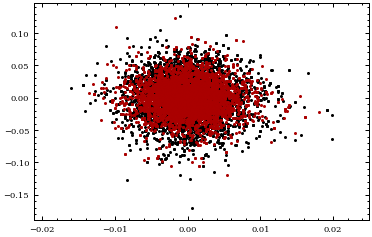

In [8]:
plt.scatter(X[:, 0], X[:, 1], zorder=2)
plt.scatter(Xr2[:, 0], Xr2[:, 1], zorder=3)
#plt.scatter(Xp2[:, 0], Xp2[:, 1], zorder=1)
plt.show()

In [9]:
c = np.cov(X, rowvar=False)
cr = np.cov(Xr2, rowvar=False)
print np.diagonal(cr)/np.trace(c)
print c
print cr

[2.62159984e-04 1.23069659e-02 1.50415029e-02 2.95001075e-02
 1.93118630e-02 1.54694254e-02 1.70247100e-02 1.02576474e-02
 1.64946590e-02 1.59983592e-02 1.56370659e-02 2.30211829e-02
 4.12939123e-03 5.30812888e-03 1.27559897e-02 3.23893660e-03
 1.28065771e-02 8.62227341e-03 2.44905478e-03 8.89332753e-03
 1.13479870e-02 6.45159949e-03 4.23242947e-03 5.02124268e-03
 1.29890159e-02 3.97187684e-03 1.56613616e-02 4.12273106e-03
 1.92911101e-03 1.83584926e-03 2.02529410e-03 5.97994646e-03
 8.81158734e-03 9.12058518e-03 4.09569719e-03 2.65330547e-03
 2.45375906e-03 2.29650534e-03 4.09486465e-03 1.49038095e-03
 3.14060870e-03 2.67330416e-03 2.70286680e-03 4.99429722e-03
 6.36544781e-03 1.04701490e-02 6.78667686e-03 8.91761942e-04
 3.52842011e-03 7.68242502e-03 1.02922629e-03 2.95280224e-03
 1.57506134e-03 1.07449518e-03 9.51046143e-04 2.14837362e-03
 4.15163238e-03 9.65194801e-04 2.07166546e-03 1.48606433e-03
 6.99118123e-04 2.11197293e-03 6.81220268e-03 4.41135819e-03
 1.17332768e-03 1.141770

In [10]:
print np.linalg.norm(X)
print pca.singular_values_
print np.sqrt(U2)*np.linalg.norm(X)

for alpha in (0.01, 0.25, 0.5, 0.75, 0.99, 1.0):
    Xp3, Xr3, Yp3, U3, By3 = PCovR(X, Y, n_pca=n_pca, alpha=alpha)
    print "---- Alpha =", alpha, "-----"
    print pca.explained_variance_ratio_
    print U3[0:n_pca]
    
    print np.sum(pca.explained_variance_ratio_)
    print np.sum(U3)

16.289450565650224
[8.13655109 7.01970274 6.60039371 4.59797751 3.24927203 3.09334507
 2.4402399  2.27227193 1.76503836 1.68067738]
[1.45551580e+01 7.29988541e+00 2.96513818e-03 2.51581040e-03
 2.00921476e-03 1.78794593e-03 1.52385841e-03 1.45776725e-03
 1.31746921e-03 1.22223332e-03 1.18774538e-03 1.16137552e-03
 1.11486378e-03 1.04638497e-03 9.81488498e-04 9.54746332e-04
 9.03700132e-04 8.27866787e-04 8.21697315e-04 7.85277869e-04
 7.30638873e-04 7.07328884e-04 6.65703803e-04 6.64355817e-04
 6.57462001e-04 6.51146046e-04 6.40414105e-04 5.90138375e-04
 5.89315916e-04 5.81742074e-04 5.58659714e-04 5.51455848e-04
 5.37380157e-04 5.28029836e-04 5.10376089e-04 5.03173561e-04
 5.01084155e-04 4.78080506e-04 4.61886536e-04 4.54333843e-04
 4.53784654e-04 4.41280845e-04 4.36330781e-04 4.33556569e-04
 4.30523268e-04 4.12743770e-04 4.12114512e-04 4.03863658e-04
 3.91568554e-04 3.87548736e-04 3.84881848e-04 3.82132166e-04
 3.73237489e-04 3.71653365e-04 3.69132766e-04 3.61371703e-04
 3.48721471e-0

In [11]:
print Xp2[:, 0:10]
print Xpca_white[:, 0:10]
print Xpca[:, 0:10]

[[-2.16235271e-01  1.80951496e-02 -9.75622040e-05 ...  5.49810090e-06
  -9.11129901e-06 -4.99454420e-05]
 [ 8.70519746e-02 -1.10496549e-01 -1.63832258e-05 ...  8.79265977e-06
  -2.11705996e-06 -2.34444575e-06]
 [ 8.39472365e-02 -8.13513769e-02  3.41337241e-05 ...  4.92973856e-05
  -1.16464168e-05 -2.15714162e-05]
 ...
 [ 5.61023122e-02  5.04505179e-02  2.73946662e-05 ...  2.72868667e-05
  -4.72799049e-08  1.76690341e-05]
 [ 5.61023538e-02  5.04505190e-02  2.73946783e-05 ...  2.72868621e-05
  -4.72868921e-08  1.76690347e-05]
 [ 5.61023126e-02  5.04505179e-02  2.73946654e-05 ...  2.72868672e-05
  -4.72792346e-08  1.76690348e-05]]
[[-0.00039182 -0.01608382  0.01291608 ...  0.0161501   0.01245433
   0.03262663]
 [ 0.00259576  0.01858709  0.01482793 ...  0.02932453 -0.01013801
   0.00781612]
 [ 0.02538053  0.00177378  0.00556505 ... -0.00889474 -0.01618691
  -0.0279415 ]
 ...
 [-0.02178764  0.01213899 -0.02349583 ...  0.00156848  0.0005542
  -0.00272716]
 [-0.02178764  0.01213899 -0.0234958

In [12]:
v = np.var(Xpca, axis=0)
print v/v[0]
print U2/U2[0]
v2 = np.var(Xp2, axis=0)
print v2/v2[0]

[1.         0.74431493 0.65805012 0.31933974 0.15947457 0.144536
 0.08994651 0.07799017 0.04705736 0.0426666 ]
[1.00000000e+00 2.51534892e-01 4.15007577e-08 2.98759669e-08
 1.90554352e-08 1.50895022e-08 1.09611315e-08 1.00309607e-08
 8.19307826e-09 7.05138439e-09 6.65905880e-09 6.36665751e-09
 5.86691460e-09 5.16831696e-09 4.54712174e-09 4.30271074e-09
 3.85491534e-09 3.23509525e-09 3.18705742e-09 2.91080337e-09
 2.51983267e-09 2.36161413e-09 2.09183887e-09 2.08337591e-09
 2.04036313e-09 2.00134964e-09 1.93592234e-09 1.64389421e-09
 1.63931530e-09 1.59744937e-09 1.47319713e-09 1.43544860e-09
 1.36310530e-09 1.31608239e-09 1.22955169e-09 1.19509321e-09
 1.18518868e-09 1.07886778e-09 1.00701690e-09 9.74353005e-10
 9.71998878e-10 9.19170981e-10 8.98665059e-10 8.87273875e-10
 8.74902000e-10 8.04131744e-10 8.01681696e-10 7.69902451e-10
 7.23738651e-10 7.08955218e-10 6.99231543e-10 6.89276300e-10
 6.57561945e-10 6.51992036e-10 6.43178248e-10 6.16416760e-10
 5.74015379e-10 5.64025760e-10 5.41

--- Alpha = 0.01 ---
[0.00312947 0.00548957 0.003567  ]
0.16209163528671366
--- Alpha = 0.25 ---
[0.00312915 0.00549006 0.00356663]
0.17332073661405284
--- Alpha = 0.5 ---
[0.00312851 0.0054911  0.0035664 ]
0.23918542192813794
--- Alpha = 0.75 ---
[0.003127   0.0054891  0.00356711]
0.5190165729618682
--- Alpha = 0.99 ---
[0.00312521 0.00477097 0.00358498]
2.624226797842958


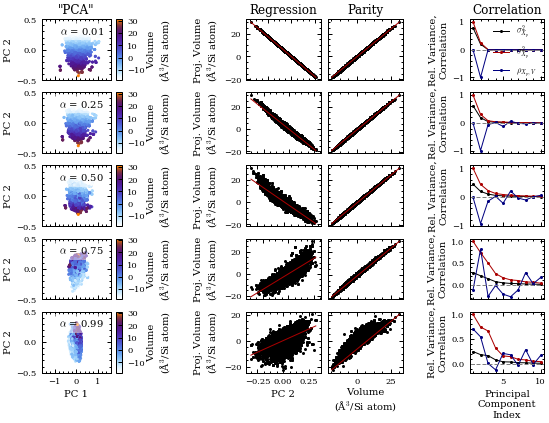

In [13]:
fig = plt.figure(figsize=(9.0, 6.5))
gs = mpl.gridspec.GridSpec(5, 6, width_ratios=(1, 0.65, 0.65, 0.65, 0.45, 0.65), hspace=0.2, wspace=0.1)

varX = np.trace(np.cov(X, rowvar=False))

for adx, a in enumerate((0.01, 0.25, 0.50, 0.75, 0.99)):
    axsPCA = fig.add_subplot(gs[adx, 0])
    axsLR = fig.add_subplot(gs[adx, 2])
    axsP = fig.add_subplot(gs[adx, 3])
    axsCorr = fig.add_subplot(gs[adx, 5])
    
    # PCovR
    Xp, Xr, Yp, U, By = PCovR(X, Y, alpha=a, n_pca=n_pca)
    m, b, r, p, s = linregress(Xp[:, 1], Yp[:, 0])
    
    varXp = np.diagonal(np.cov(Xp, rowvar=False))
    varXr = np.diagonal(np.cov(Xr, rowvar=False))

    print '--- Alpha =', a, '---'
    print np.mean(np.abs(X[:, 0:n_pca]-Xr[:, 0:n_pca]), axis=0)[0:3]
    print np.mean(np.abs(Y[:, 0]-Yp[:, 0]))
    
    # Correlation coefficients
    ccV = np.zeros(n_pca)

    for i in range(0, n_pca):
        #ccV[i] = cc(Xp[:, i], Y[:, 0])
        ccV[i] = cc(Xp[:, i], Yp[:, 0])

    # Plotting
    s = axsPCA.scatter(Xp[:, 0], Xp[:, 1], c=Y[:, 0], cmap='cbarHot')
    axsPCA.set_xlim([-1.6, 1.6])
    axsPCA.set_ylim([-0.50, 0.50])
    #axsPCA.scatter(Xpca[:, 0], -Xpca[:, 1], c='gray', alpha=1)
    if adx == 0:
        axsPCA.set_title('"PCA"')
    if adx == 4:
        axsPCA.set_xlabel('PC 1')
    else:
        axsPCA.set_xticklabels([])
        
    axsPCA.set_ylabel('PC 2')
    
    axsLR.scatter(Xp[:, 1], Yp[:, 0])
    x = np.linspace(Xp[:, 1].min(), Xp[:, 1].max())
    axsLR.plot(x, m*x+b, linestyle='-', color=color_list[1])
    if adx == 0:
        axsLR.set_title('Regression')
    if adx == 4:
        axsLR.set_xlabel('PC 2')
    else:
        axsLR.set_xticklabels([])
        
    axsLR.set_ylabel('Proj. Volume\n' + ur'(\u00c5$^3$/Si atom)')
    
    axsP.scatter(Y[:, 0], Yp[:, 0])
    axsP.plot([Y[:, 0].min(), Y[:, 0].max()], [Yp[:, 0].min(), Yp[:, 0].max()], color=color_list[1])
    if adx == 0:
        axsP.set_title('Parity')
    if adx == 4:
        axsP.set_xlabel('Volume\n' + ur'(\u00c5$^3$/Si atom)')
    else:
        axsP.set_xticklabels([])
        
    axsP.set_yticklabels([])
    
    x = np.arange(1, n_pca_plot+1)
    axsCorr.plot(x, varXp[0:n_pca_plot]/varX, marker='o', label=r'$\sigma^2_{X_p}$')
    axsCorr.plot(x, U[0:n_pca_plot]/U[0], marker='o', label=r'$\sigma^2_{X_p}$')
    axsCorr.plot(x, ccV[0:n_pca_plot], marker='o', label=r'$\rho_{X_p, V}$')
    if adx == 0:
        axsCorr.set_title('Correlation')
        axsCorr.legend(loc='upper right', bbox_to_anchor=(1.0, 1.05))
    if adx == 4:
        axsCorr.set_xlabel('Principal\nComponent\nIndex')
    else:
        axsCorr.set_xticklabels([])
        
    #axsCorr.set_ylim([-1.1, 1.1])
    axsCorr.set_ylabel('Rel. Variance,\nCorrelation')
    axsCorr.axhline(y=0, linestyle='--', color='gray')
    
    cb = fig.colorbar(s, ax=axsPCA, aspect=10, fraction=0.35)
    cb.set_label('Volume\n' + ur'(\u00c5$^3$/Si atom)')
    cb.ax.minorticks_off()
    
    axsPCA.text(0.90, 0.90, r'$\alpha$ = %.2f' % a, 
                horizontalalignment='right', verticalalignment='top',
                transform=axsPCA.transAxes, bbox=dict(facecolor='w', alpha=0.5, edgecolor='none'))

#fig.savefig('../Results/DEEM_1k/PCovR_volumes_test.pdf', bbox_inches='tight')
#fig.savefig('../Results/DEEM_1k/PCovR_volumes_test.png', bbox_inches='tight')
plt.show()

In [14]:
print np.trace(np.cov(X, rowvar=False))
print np.trace(np.dot(X.T, X))/4999

0.05307985591733567
0.05307985591733566


--- Alpha = 0.01 ---
[0.00312947 0.00548957 0.003567  ]
0.2918661828667901
--- Alpha = 0.25 ---
[0.00312915 0.00549006 0.00356663]
0.2926860053907418
--- Alpha = 0.5 ---
[0.00312851 0.0054911  0.0035664 ]
0.3014184261287904
--- Alpha = 0.75 ---
[0.003127   0.0054891  0.00356711]
0.3840512226451497
--- Alpha = 0.99 ---
[0.00312521 0.00477097 0.00358498]
5.650497469837104


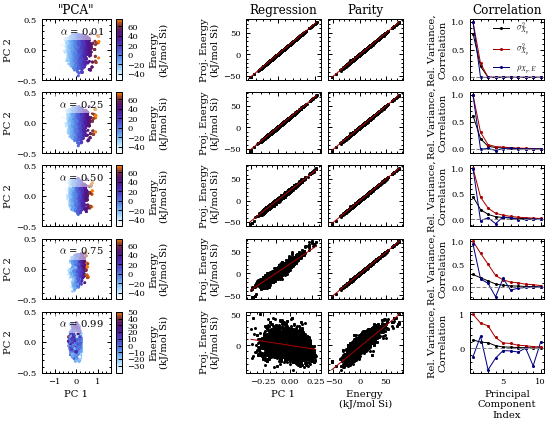

In [15]:
fig = plt.figure(figsize=(9.0, 6.5))
gs = mpl.gridspec.GridSpec(5, 6, width_ratios=(1, 0.65, 0.65, 0.65, 0.45, 0.65), hspace=0.2, wspace=0.1)

varX = np.trace(np.cov(X, rowvar=False))

for adx, a in enumerate((0.01, 0.25, 0.50, 0.75, 0.99)):
    axsPCA = fig.add_subplot(gs[adx, 0])
    axsLR = fig.add_subplot(gs[adx, 2])
    axsP = fig.add_subplot(gs[adx, 3])
    axsCorr = fig.add_subplot(gs[adx, 5])
    
    # PCovR
    Xp, Xr, Yp, U, By = PCovR(X, Y, alpha=a, n_pca=n_pca)
    m, b, r, p, s = linregress(Xp[:, 0], Yp[:, 1])
    
    varXp = np.diagonal(np.cov(Xp, rowvar=False))
    varXr = np.diagonal(np.cov(Xr, rowvar=False))

    print '--- Alpha =', a, '---'
    print np.mean(np.abs(X[:, 0:n_pca]-Xr[:, 0:n_pca]), axis=0)[0:3]
    print np.mean(np.abs(Y[:, 1]-Yp[:, 1]))
    
    # Correlation coefficients
    ccE = np.zeros(n_pca)

    for i in range(0, n_pca):
        #ccE[i] = cc(Xp[:, i], Y[:, 1])
        ccE[i] = cc(Xp[:, i], Yp[:, 1])

    # Plotting
    s = axsPCA.scatter(Xp[:, 0], Xp[:, 1], c=Yp[:, 1], cmap='cbarHot')
    axsPCA.set_xlim([-1.6, 1.6])
    axsPCA.set_ylim([-0.50, 0.50])
    #axsPCA.scatter(Xpca[:, 0], -Xpca[:, 1], c='gray', alpha=1)
    if adx == 0:
        axsPCA.set_title('"PCA"')
    if adx == 4:
        axsPCA.set_xlabel('PC 1')
    else:
        axsPCA.set_xticklabels([])
        
    axsPCA.set_ylabel('PC 2')
    
    axsLR.scatter(Xp[:, 0], Yp[:, 1])
    x = np.linspace(Xp[:, 0].min(), Xp[:, 0].max())
    axsLR.plot(x, m*x+b, linestyle='-', color=color_list[1])
    if adx == 0:
        axsLR.set_title('Regression')
    if adx == 4:
        axsLR.set_xlabel('PC 1')
    else:
        axsLR.set_xticklabels([])
        
    axsLR.set_ylabel('Proj. Energy\n(kJ/mol Si)')
    
    axsP.scatter(Y[:, 1], Yp[:, 1])
    axsP.plot([Y[:, 1].min(), Y[:, 1].max()], [Yp[:, 1].min(), Yp[:, 1].max()], color=color_list[1])
    if adx == 0:
        axsP.set_title('Parity')
    if adx == 4:
        axsP.set_xlabel('Energy \n(kJ/mol Si)')
    else:
        axsP.set_xticklabels([])
        
    axsP.set_yticklabels([])
    
    x = np.arange(1, n_pca_plot+1)
    axsCorr.plot(x, varXp[0:n_pca_plot]/varX, marker='o', label=r'$\sigma^2_{X_p}$')
    #axsCorr.plot(x, varXr[0:n_pca_plot]/varX, marker='o', label=r'$\sigma^2_{X_r}$')
    axsCorr.plot(x, U[0:n_pca_plot]/U[0], marker='o', label=r'$\sigma^2_{X_p}$')
    axsCorr.plot(x, ccE[0:n_pca_plot], marker='o', label=r'$\rho_{X_p, E}$')
    if adx == 0:
        axsCorr.set_title('Correlation')
        axsCorr.legend(loc='lower right', bbox_to_anchor=(1.0, -0.05))
    if adx == 4:
        axsCorr.set_xlabel('Principal\nComponent\nIndex')
    else:
        axsCorr.set_xticklabels([])
       
    #axsCorr.set_ylim([-1.1, 1.1])
    axsCorr.set_ylabel('Rel. Variance,\nCorrelation')
    axsCorr.axhline(y=0, linestyle='--', color='gray')
    
    cb = fig.colorbar(s, ax=axsPCA, aspect=10, fraction=0.35)
    cb.set_label('Energy\n(kJ/mol Si)')
    cb.ax.minorticks_off()
    
    axsPCA.text(0.90, 0.90, r'$\alpha$ = %.2f' % a, 
                horizontalalignment='right', verticalalignment='top',
                transform=axsPCA.transAxes, bbox=dict(facecolor='w', alpha=0.5, edgecolor='none'))
    
    fig.align_ylabels()

#fig.savefig('../Results/DEEM_1k/PCovR_energies_test.pdf', bbox_inches='tight')
#fig.savefig('../Results/DEEM_1k/PCovR_energies_test.png', bbox_inches='tight')
plt.show()

In [16]:
n_alpha = 21
alphas = np.linspace(0.0, 1.0, n_alpha)
#alphas = np.logspace(-4, 0, n_alpha)
components = np.arange(2, 6, dtype=np.int)
n_components = components.size
L_pca = np.zeros((n_components, n_alpha))
L_lr = np.zeros((n_components, n_alpha))

for cdx, c in enumerate(components):
    for adx, a in enumerate(alphas):
        _Xp, _Xr, _Yp, _U, _By, L_pca[cdx, adx], L_lr[cdx, adx] = PCovR(X, Y, alpha=a, n_pca=c, loss=True)
    print 'pca =', c

pca = 2
pca = 3
pca = 4
pca = 5


In [17]:
np.savetxt('pca.dat', Xpca)
np.savetxt('pcovr.dat', Xp2)

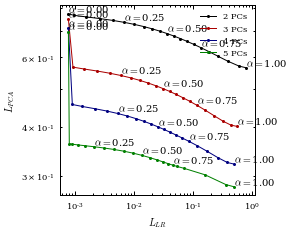

In [18]:
fig = plt.figure(figsize=(3.5, 3.5))
axs = fig.add_subplot(1, 1, 1)

for i in range(0, L_pca.shape[0]):
    axs.loglog(L_lr[i, :], L_pca[i, :], marker='o', label='%d PCs' % (i+2))
    for jdx, j in enumerate(alphas):
        if jdx % 5 == 0:
            axs.text(L_lr[i, jdx], L_pca[i, jdx], r'$\alpha = $' + '%.2f' % j, 
                    horizontalalignment='left', verticalalignment='bottom')

#axs.set_xlim([0.028, 0.03])
axs.set_xlabel(r'$L_{LR}$')
axs.set_ylabel(r'$L_{PCA}$')
#axs.set_xlim([0.8464, 0.847])
#axs.set_ylim([0.0285, 0.0288])
#axs.set_yticks([0.0285, 0.0288])
#axs.set_xticks([0.8464, 0.847])

axs.legend()

#fig.savefig('../Results/DEEM_1k/PCovR_loss_test.pdf', bbox_inches='tight')
#fig.savefig('../Results/DEEM_1k/PCovR_loss_test.png', bbox_inches='tight')
plt.show()

0.5
0.5
0.5
0.5


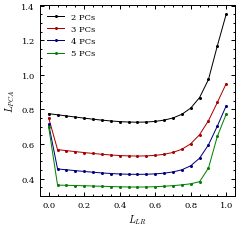

In [19]:
fig = plt.figure(figsize=(3.5, 3.5))
axs = fig.add_subplot(1, 1, 1)

for i in range(0, L_pca.shape[0]):
    axs.plot(alphas, L_lr[i, :] + L_pca[i, :], marker='o', label='%d PCs' % (i+2))
    print alphas[np.argmin(L_lr[i, :] + L_pca[i, :])]

#axs.set_xlim([0.028, 0.03])
axs.set_xlabel(r'$L_{LR}$')
axs.set_ylabel(r'$L_{PCA}$')
#axs.set_xlim([0.8464, 0.847])
#axs.set_ylim([0.0285, 0.0288])
#axs.set_yticks([0.0285, 0.0288])
#axs.set_xticks([0.8464, 0.847])

axs.legend()

#fig.savefig('../Results/DEEM_1k/PCovR_loss_sum_test.pdf', bbox_inches='tight')
#fig.savefig('../Results/DEEM_1k/PCovR_loss_sum_test.png', bbox_inches='tight')
plt.show()

In [25]:
Xp, Xr, Yp, U, By = PCovR(X, Y, alpha=0.0, n_pca=2)
sklr = LinearRegression()
sklr.fit(X, Y)
skyp = sklr.predict(X)

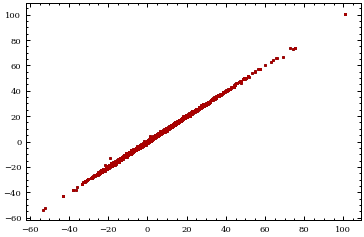

0.2287718703202716
0.22877191967885124
3.7756944077926846e-05


In [27]:
plt.scatter(Y, skyp)
plt.scatter(Y, Yp)
plt.show()
print np.mean(np.abs(Y-skyp))
print np.mean(np.abs(Y-Yp))
print np.amax(np.abs(Yp-skyp))